In [158]:
# %matplotlib widget
from matplotlib import pyplot as plt
from IPython.display import Audio
import scipy
import numpy as np
from pathlib import Path
from IPython.display import HTML
from IPython.display import display, clear_output
import ipywidgets as widgets
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import mpl_interactions.ipyplot as iplt
from mpl_interactions.widgets import scatter_selector_index
import sounddevice as sd
import random
# HTML('''<style>.jupyter-matplotlib {background-color: #000;}.widget-label{color: #fff;}.jupyter-matplotlib-header{color: #000!important;}.jupyter-button {background-color: #333;color: #fff;}</style>''')
plt.style.use('default')

In [39]:
def load_samples(path, label):
	samples = []
	for sample_path in path.glob('*.wav'):
		sample_rate, sample = scipy.io.wavfile.read(sample_path)
		# sample = sample.mean(axis=1)
		# trim silence
		start_i = np.argmax(sample > 0.005)
		samples.append((sample[start_i:], label))
	return samples

low_dataset =  load_samples(Path('dataset/cut_filtered/kck0'), 0) + load_samples(Path('dataset/cut_filtered/kck1'), 0) + load_samples(Path('dataset/cut_filtered/kck2'), 0) + load_samples(Path('dataset/cut_filtered/kck3'), 0) 
high_dataset =  load_samples(Path('dataset/cut_filtered/snr0'), 1) + load_samples(Path('dataset/cut_filtered/snr1'), 1) + load_samples(Path('dataset/cut_filtered/snr2'), 1) + load_samples(Path('dataset/cut_filtered/snr3'), 1)
print(f"Low dataset size: {len(low_dataset)}")
print(f"High dataset size: {len(high_dataset)}")

random.shuffle(low_dataset)
random.shuffle(high_dataset)

split = len(low_dataset)//4
test_dataset_raw = low_dataset[:split] + high_dataset[:split]
train_dataset_raw = low_dataset[split:] + high_dataset[split:]
random.shuffle(train_dataset_raw)
random.shuffle(test_dataset_raw)

print(f"Train dataset size: {len(train_dataset_raw)}")
print(f"Test dataset size: {len(test_dataset_raw)}")

Low dataset size: 264
High dataset size: 277
Train dataset size: 409
Test dataset size: 132


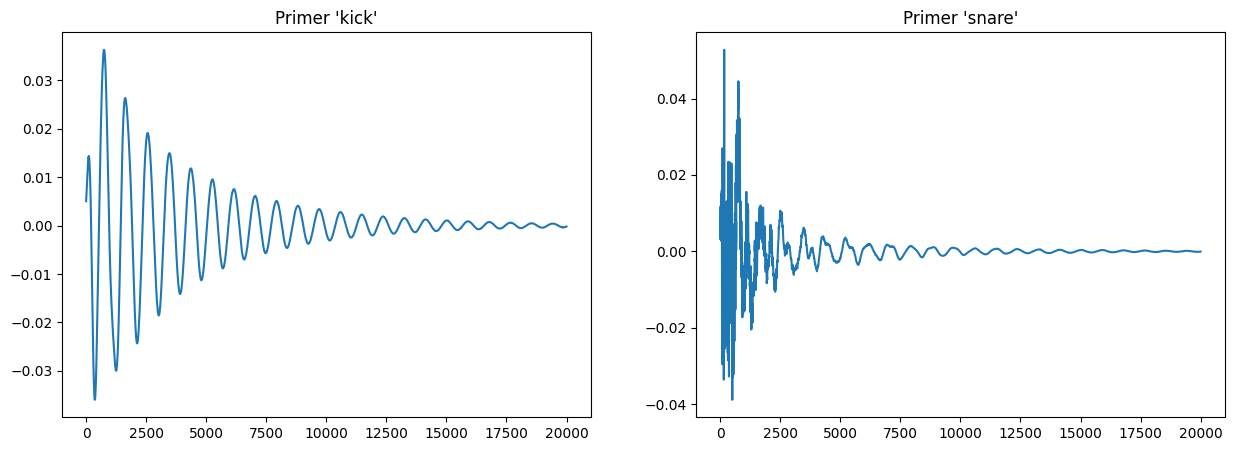

In [91]:
# Prikaz različnih velikosti okna glede na signal

ws = 20000
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Primer 'kick'")
plt.plot(low_dataset[3][0][:ws])
# plt.plot(low_dataset[51][0][:ws])
# plt.axvline(64, color='r', linestyle='-')
# plt.axvline(128, color='r', linestyle='-')
# plt.axvline(256, color='r', linestyle='-')
# plt.axvline(512, color='r', linestyle='-')
# plt.xticks([0, 64, 128, 256, 512], ['0', '64', '128', '256', '512'])
plt.subplot(1, 2, 2)
plt.title("Primer 'snare'")
plt.plot(high_dataset[1][0][:ws])
# plt.plot(high_dataset[50][0][:ws])
# plt.axvline(64, color='r', linestyle='-')
# plt.axvline(128, color='r', linestyle='-')
# plt.axvline(256, color='r', linestyle='-')
# plt.axvline(512, color='r', linestyle='-')
# plt.xticks([0, 64, 128, 256, 512], ['0', '64', '128', '256', '512'])
plt.savefig('primer_kick_snare.png', dpi=300)
plt.show()

In [3]:
def preprocess_sample(sample, window_size):
	sample = sample[:window_size]
	sample_fft = np.abs(np.fft.rfft(sample))
	return sample_fft

def preprocess_dataset(dataset, window_size):
		samples_preprocessed = []
		for sample, label in dataset:
			sample_fft = preprocess_sample(sample, window_size)
			samples_preprocessed.append((sample_fft, label))
		return samples_preprocessed

Window size: 64 samples, 1.45 ms
Window size: 128 samples, 2.90 ms
Window size: 256 samples, 5.80 ms
Window size: 512 samples, 11.61 ms


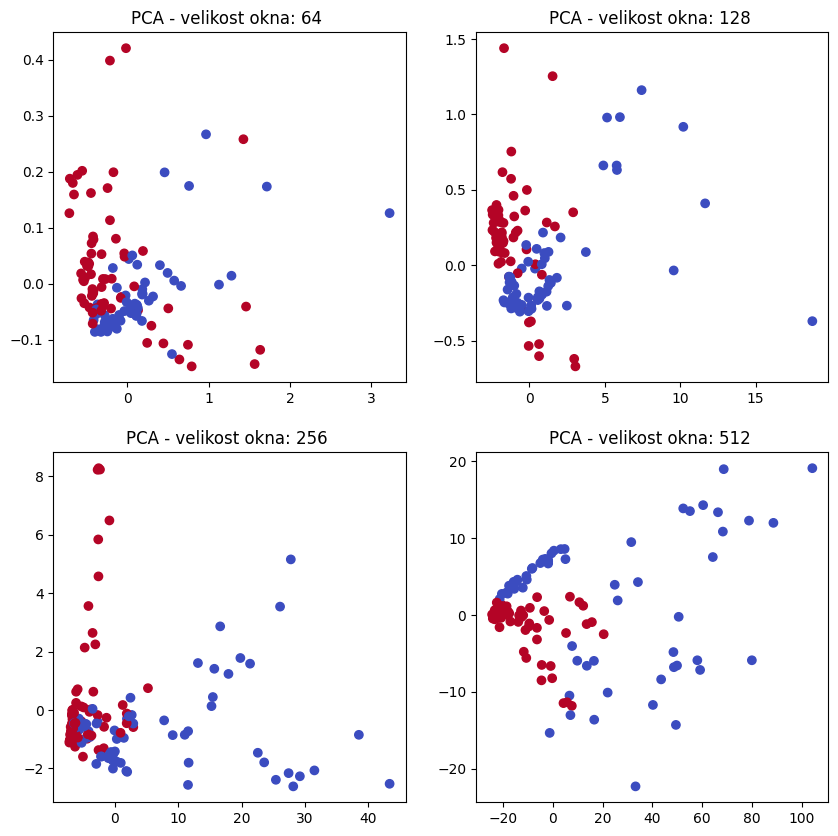

In [100]:
plt.figure(figsize=(10, 10))
for i, window_size in enumerate([64, 128, 256, 512]):
	print(f"Window size: {window_size} samples, {window_size/44100*1000:.2f} ms")

	# Preprocess the dataset - apply FFT and trim to window size
	train_dataset = preprocess_dataset(train_dataset_raw, window_size)
	test_dataset = preprocess_dataset(test_dataset_raw, window_size)

	train_samples = np.array([sample for sample, label in train_dataset])
	train_labels = np.array([label for sample, label in train_dataset])

	test_samples = np.array([sample for sample, label in test_dataset])
	test_labels = np.array([label for sample, label in test_dataset])

	pca = PCA(n_components=2)
	pca.fit(train_samples)

	samples_pca = pca.transform(test_samples)
	
	plt.subplot(2, 2, i+1)
	plt.title(f'PCA - velikost okna: {window_size} ')
	plt.scatter(samples_pca[:, 0], samples_pca[:, 1], c=test_labels, cmap='coolwarm')

plt.savefig('img/pca_fft.png', dpi=300)
	

Window size: 64 samples, 1.45 ms
Train accuracy 64: 0.8899755501222494
Test accruacy 64 0.8712121212121212
Window size: 128 samples, 2.90 ms
Train accuracy 128: 0.980440097799511
Test accruacy 128 0.9393939393939394
Window size: 256 samples, 5.80 ms
Train accuracy 256: 1.0
Test accruacy 256 0.9696969696969697
Window size: 512 samples, 11.61 ms
Train accuracy 512: 1.0
Test accruacy 512 1.0


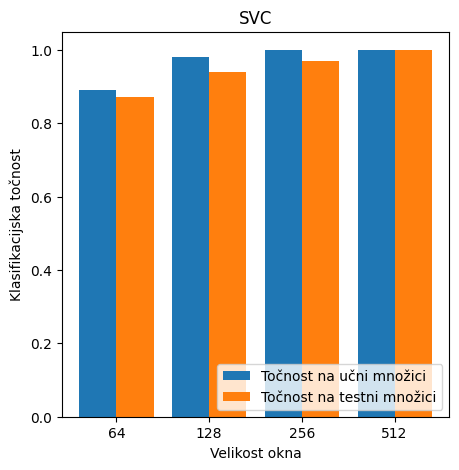

In [156]:
winodw_sizes = [64, 128, 256, 512]
test_accuracies = []
train_accuracies = []
for i, window_size in enumerate([64, 128, 256, 512]):
	print(f"Window size: {window_size} samples, {window_size/44100*1000:.2f} ms")

	# Preprocess the dataset - apply FFT and trim to window size
	train_dataset = preprocess_dataset(train_dataset_raw, window_size)
	test_dataset = preprocess_dataset(test_dataset_raw, window_size)

	train_samples = np.array([sample for sample, label in train_dataset])
	train_labels = np.array([label for sample, label in train_dataset])

	test_samples = np.array([sample for sample, label in test_dataset])
	test_labels = np.array([label for sample, label in test_dataset])

	svc =  SVC(kernel='linear', C=0.7)
	clf = make_pipeline(StandardScaler(), svc)
	clf.fit(train_samples, train_labels)
	train_accuracy = accuracy_score(clf.predict(train_samples), train_labels)
	print(f"Train accuracy {window_size}: {train_accuracy}")
	labels = clf.predict(test_samples)
	test_accuracy = accuracy_score(labels, test_labels)
	print(f"Test accruacy {window_size} {test_accuracy}")
	test_accuracies.append(test_accuracy)
	train_accuracies.append(train_accuracy)

plt.figure(figsize=(5, 5))
plt.bar([1, 3, 5, 7], train_accuracies, label='Točnost na učni množici')
plt.bar([x-0.2 for x in [2, 4, 6, 8]], test_accuracies, label='Točnost na testni množici')
plt.xticks([x+0.4 for x in [1, 3, 5, 7]], ['64', '128', '256', '512'])
plt.xlabel('Velikost okna')
plt.ylabel('Klasifikacijska točnost')
plt.title('SVC')
plt.legend(loc="lower right")
plt.savefig('img/svc_fft.png', dpi=300)

Window size: 64 samples, 1.45 ms
Train accuracy 64: 0.7799511002444988
Test accruacy 64 0.7651515151515151
Window size: 128 samples, 2.90 ms
Train accuracy 128: 0.8166259168704156
Test accruacy 128 0.9015151515151515
Window size: 256 samples, 5.80 ms
Train accuracy 256: 0.9633251833740831
Test accruacy 256 0.946969696969697
Window size: 512 samples, 11.61 ms
Train accuracy 512: 0.9926650366748166
Test accruacy 512 0.9696969696969697


c:\Users\jezersek\.pyenv\pyenv-win\versions\3.11.4\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


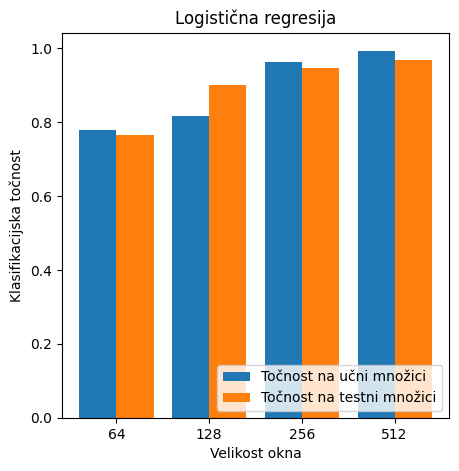

In [149]:
winodw_sizes = [64, 128, 256, 512]
test_accuracies = []
train_accuracies = []
for i, window_size in enumerate([64, 128, 256, 512]):
	print(f"Window size: {window_size} samples, {window_size/44100*1000:.2f} ms")

	# Preprocess the dataset - apply FFT and trim to window size
	train_dataset = preprocess_dataset(train_dataset_raw, window_size)
	test_dataset = preprocess_dataset(test_dataset_raw, window_size)

	train_samples = np.array([sample for sample, label in train_dataset])
	train_labels = np.array([label for sample, label in train_dataset])

	test_samples = np.array([sample for sample, label in test_dataset])
	test_labels = np.array([label for sample, label in test_dataset])

	clf = linear_model.LogisticRegression()
	clf.fit(train_samples, train_labels)
	train_accuracy = accuracy_score(clf.predict(train_samples), train_labels)
	print(f"Train accuracy {window_size}: {train_accuracy}")
	labels = clf.predict(test_samples)
	test_accuracy = accuracy_score(labels, test_labels)
	print(f"Test accruacy {window_size} {test_accuracy}")
	test_accuracies.append(test_accuracy)
	train_accuracies.append(train_accuracy)

plt.figure(figsize=(5, 5))
plt.bar([1, 3, 5, 7], train_accuracies, label='Točnost na učni množici')
plt.bar([x-0.2 for x in [2, 4, 6, 8]], test_accuracies, label='Točnost na testni množici')
plt.xticks([x+0.4 for x in [1, 3, 5, 7]], ['64', '128', '256', '512'])
plt.xlabel('Velikost okna')
plt.ylabel('Klasifikacijska točnost')
plt.title('Logistična regresija')
plt.legend(loc="lower right")
plt.savefig('img/logreg_fft.png', dpi=300)

Window size: 64 samples, 1.45 ms
Train accuracy 64: 1.0
Test accruacy 64 0.9015151515151515
Window size: 128 samples, 2.90 ms
Train accuracy 128: 1.0
Test accruacy 128 0.9924242424242424
Window size: 256 samples, 5.80 ms
Train accuracy 256: 1.0
Test accruacy 256 0.9545454545454546
Window size: 512 samples, 11.61 ms
Train accuracy 512: 1.0
Test accruacy 512 0.9924242424242424


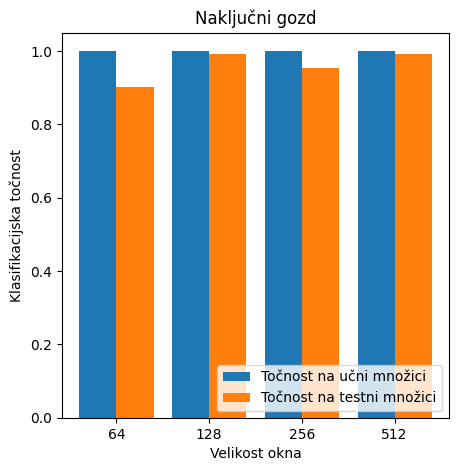

In [157]:
winodw_sizes = [64, 128, 256, 512]
test_accuracies = []
train_accuracies = []
for i, window_size in enumerate([64, 128, 256, 512]):
	print(f"Window size: {window_size} samples, {window_size/44100*1000:.2f} ms")

	# Preprocess the dataset - apply FFT and trim to window size
	train_dataset = preprocess_dataset(train_dataset_raw, window_size)
	test_dataset = preprocess_dataset(test_dataset_raw, window_size)

	train_samples = np.array([sample for sample, label in train_dataset])
	train_labels = np.array([label for sample, label in train_dataset])

	test_samples = np.array([sample for sample, label in test_dataset])
	test_labels = np.array([label for sample, label in test_dataset])

	clf = RandomForestClassifier(max_depth=20)
	clf.fit(train_samples, train_labels)
	train_accuracy = accuracy_score(clf.predict(train_samples), train_labels)
	print(f"Train accuracy {window_size}: {train_accuracy}")
	labels = clf.predict(test_samples)
	test_accuracy = accuracy_score(labels, test_labels)
	print(f"Test accruacy {window_size} {test_accuracy}")
	test_accuracies.append(test_accuracy)
	train_accuracies.append(train_accuracy)

plt.figure(figsize=(5, 5))
plt.bar([1, 3, 5, 7], train_accuracies, label='Točnost na učni množici')
plt.bar([x-0.2 for x in [2, 4, 6, 8]], test_accuracies, label='Točnost na testni množici')
plt.xticks([x+0.4 for x in [1, 3, 5, 7]], ['64', '128', '256', '512'])
plt.xlabel('Velikost okna')
plt.ylabel('Klasifikacijska točnost')
plt.title('Naključni gozd')
plt.legend(loc="lower right")
plt.savefig('img/gozd_fft.png', dpi=300)

Window size: 64 samples, 1.45 ms
Train accuracy 64: 0.8704156479217604
Test accruacy 64 0.9015151515151515
Window size: 128 samples, 2.90 ms
Train accuracy 128: 0.9828850855745721
Test accruacy 128 0.9772727272727273
Window size: 256 samples, 5.80 ms
Train accuracy 256: 1.0
Test accruacy 256 0.9848484848484849
Window size: 512 samples, 11.61 ms
Train accuracy 512: 1.0
Test accruacy 512 1.0


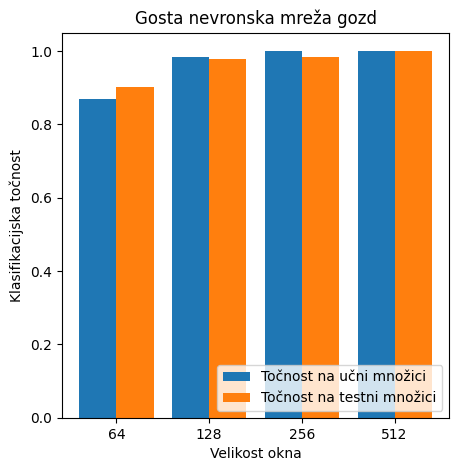

In [159]:
winodw_sizes = [64, 128, 256, 512]
test_accuracies = []
train_accuracies = []
for i, window_size in enumerate([64, 128, 256, 512]):
	print(f"Window size: {window_size} samples, {window_size/44100*1000:.2f} ms")

	# Preprocess the dataset - apply FFT and trim to window size
	train_dataset = preprocess_dataset(train_dataset_raw, window_size)
	test_dataset = preprocess_dataset(test_dataset_raw, window_size)

	train_samples = np.array([sample for sample, label in train_dataset])
	train_labels = np.array([label for sample, label in train_dataset])

	test_samples = np.array([sample for sample, label in test_dataset])
	test_labels = np.array([label for sample, label in test_dataset])

	clf = MLPClassifier(hidden_layer_sizes=(128,16), max_iter=1000)
	clf.fit(train_samples, train_labels)
	train_accuracy = accuracy_score(clf.predict(train_samples), train_labels)
	print(f"Train accuracy {window_size}: {train_accuracy}")
	labels = clf.predict(test_samples)
	test_accuracy = accuracy_score(labels, test_labels)
	print(f"Test accruacy {window_size} {test_accuracy}")
	test_accuracies.append(test_accuracy)
	train_accuracies.append(train_accuracy)

plt.figure(figsize=(5, 5))
plt.bar([1, 3, 5, 7], train_accuracies, label='Točnost na učni množici')
plt.bar([x-0.2 for x in [2, 4, 6, 8]], test_accuracies, label='Točnost na testni množici')
plt.xticks([x+0.4 for x in [1, 3, 5, 7]], ['64', '128', '256', '512'])
plt.xlabel('Velikost okna')
plt.ylabel('Klasifikacijska točnost')
plt.title('Gosta nevronska mreža gozd')
plt.legend(loc="lower right")
plt.savefig('img/nn_128_16_fft.png', dpi=300)